# Data Curation  

This notebook walks through all the steps for the analysis from gathering the data, processing the data and finally performing analysis by creating a visualization.

## Step 1: Gathering the Data  

The pagecounts and pageviews data are collected from their respective APIs and stored in 5 different json files depending on the different access types.

#### Importing required libraries...

In [7]:
import os
import shutil
import pandas as pd
import numpy as np
import functools
import datetime

import json
import requests

%matplotlib inline
import matplotlib.pyplot as plt

#### REST API endpoints:
* [Legacy Pagecounts API](https://wikimedia.org/api/rest_v1/#/Legacy%20data)
* [Pageviews API](https://wikimedia.org/api/rest_v1/#/Pageviews%20data)                    

In [8]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

#### Creating directory structure for the data

In [9]:
json_output_folder = "data/json"
csv_output_folder = "data/csv"
if os.path.exists("data"):
    shutil.rmtree("data")
os.mkdir("data")
os.mkdir(json_output_folder)
os.mkdir(csv_output_folder)

#### Creating the header for calling the APIs

In [10]:
headers = {
    'User-Agent': 'https://github.com/chavi-g',
    'From': 'chavig@uw.edu'
}

#### Creating functions to create the parameters for the APIs.

In [11]:
def get_pagecount_params(access_site, start, end):
    params = {
                "project" : "en.wikipedia.org",
                "access-site" : access_site,
                "granularity" : "monthly",
                "start" : start,
                "end" : end
           }
    return params

In [12]:
def get_pageview_params(access, start, end):
    params = {
                "project" : "en.wikipedia.org",
                "access" : access,
                "agent" : "user",
                "granularity" : "monthly",
                "start" : start,
                "end" : end
           }
    return params

#### Utility functions to call the rest APIs and store the data in files

In [13]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

In [14]:
def get_json_file_path(apiname, accesstype, firstmonth, lastmonth):
    filename = "{0}_{1}_{2}-{3}.json".format(apiname, accesstype, firstmonth, lastmonth)
    return os.path.join(json_output_folder, filename)

In [15]:
def write_data_to_json(data, filename):
    data_string = json.dumps(data, indent=2)
    with open(filename, "w") as f:
        f.write(data_string)

In [16]:
def get_pageviews_data(access, start, end):
    pageview_data = api_call(endpoint_pageviews, get_pageview_params(access, start, end))
    firstmonth = start[:6]
    endmonth = end[:6]
    filename = get_json_file_path('pageviews', access, firstmonth, endmonth)
    write_data_to_json(pageview_data, filename)
    
    return filename

In [17]:
def get_pagecounts_data(access_site, start, end):
    pagecount_data = api_call(endpoint_legacy, get_pagecount_params(access_site, start, end))
    firstmonth = start[:6]
    endmonth = end[:6]
    filename = get_json_file_path('pagecounts', access_site, firstmonth, endmonth)
    write_data_to_json(pagecount_data, filename)
    
    return filename

#### Creating json files for Pageviews API

In [18]:
start, end = "2015070100", "2020090100"
pageview_desktop_file = get_pageviews_data("desktop", start, end)
pageview_mobile_app_file = get_pageviews_data("mobile-app", start, end)
pageview_mobile_web_file = get_pageviews_data("mobile-web", start, end)

#### Creating json files for Legacy Pagecounts API

In [19]:
start, end = "2007120100", "2016070100"
pagecount_desktop_file = get_pagecounts_data("desktop-site", start, end)
pagecount_mobile_file = get_pagecounts_data("mobile-site", start, end)

## Step 2: Processing the Data

The pageview and pagecount data is processed to get counts for `mobile`, `desktop` and `all` access types.  
For doing this, the data for different access types are combined on the year and month values and added. For missing year data, the count is assumed to be 0 and thus not added.

In [20]:
def read_data_from_json(filename):
    data = {}
    with open(filename, "r") as f:
        data = json.loads(f.read())
    
    return data

In [21]:
pageview_desktop_data = read_data_from_json(pageview_desktop_file)
pageview_mobile_app_data = read_data_from_json(pageview_mobile_app_file)
pageview_mobile_web_data = read_data_from_json(pageview_mobile_web_file)
pagecount_desktop_data = read_data_from_json(pagecount_desktop_file)
pagecount_mobile_data = read_data_from_json(pagecount_mobile_file)

#### Preparing Pageview fields 
The following code aggregates the pageview counts to create the following output fields: `pageview_desktop_views`, `pageview_mobile_views`, `pageview_all_views`

In [22]:
pageview_desktop_views = pd.DataFrame(pageview_desktop_data['items'])
pageview_desktop_views['year'] = pageview_desktop_views.apply(lambda row: row['timestamp'][:4], axis = 1)
pageview_desktop_views['month'] = pageview_desktop_views.apply(lambda row: row['timestamp'][4:6], axis = 1)

In [23]:
pageview_desktop_views = pageview_desktop_views[['year', 'month', 'views']]

In [24]:
pageview_desktop_views.head()

,year,month,views
0,2015,07,4376666686
1,2015,08,4332482183
2,2015,09,4485491704
3,2015,10,4477532755
4,2015,11,4287720220


In [25]:
pageview_mobile_app_views = pd.DataFrame(pageview_mobile_app_data['items'])
pageview_mobile_app_views['year'] = pageview_mobile_app_views.apply(lambda row: row['timestamp'][:4], axis = 1)
pageview_mobile_app_views['month'] = pageview_mobile_app_views.apply(lambda row: row['timestamp'][4:6], axis = 1)

In [26]:
pageview_mobile_app_views = pageview_mobile_app_views[['year', 'month', 'views']]

In [27]:
pageview_mobile_web_views = pd.DataFrame(pageview_mobile_web_data['items'])
pageview_mobile_web_views['year'] = pageview_mobile_web_views.apply(lambda row: row['timestamp'][:4], axis = 1)
pageview_mobile_web_views['month'] = pageview_mobile_web_views.apply(lambda row: row['timestamp'][4:6], axis = 1)

In [28]:
pageview_mobile_web_views = pageview_mobile_web_views[['year', 'month', 'views']]

In [29]:
merged_pageview_mobile_views = pd.concat([pageview_mobile_app_views,pageview_mobile_web_views])

In [30]:
pageview_mobile_views = merged_pageview_mobile_views.groupby(['year', 'month']).agg({"views":['sum']}).reset_index()
pageview_mobile_views.columns = ['year', 'month', 'views']

In [31]:
pageview_mobile_views.head()

,year,month,views
0,2015,07,3288755294
1,2015,08,3302333038
2,2015,09,3170203333
3,2015,10,3268499132
4,2015,11,3236601070


In [32]:
merged_pageview_all_views = pd.concat([pageview_desktop_views, pageview_mobile_views])

In [33]:
pageview_all_views = merged_pageview_all_views.groupby(['year', 'month']).agg({"views": ['sum']}).reset_index()
pageview_all_views.columns = ['year', 'month', 'views']

In [34]:
pageview_all_views.head()

,year,month,views
0,2015,07,7665421980
1,2015,08,7634815221
2,2015,09,7655695037
3,2015,10,7746031887
4,2015,11,7524321290


#### Preparing Pagecount fields 
The following code aggregates the pagecounts to create the following output fields: `pagecount_desktop_views`, `pagecount_mobile_views`, `pagecount_all_views`

In [35]:
pagecount_desktop_views = pd.DataFrame(pagecount_desktop_data['items'])
pagecount_desktop_views['year'] = pagecount_desktop_views.apply(lambda row: row['timestamp'][:4], axis = 1)
pagecount_desktop_views['month'] = pagecount_desktop_views.apply(lambda row: row['timestamp'][4:6], axis = 1)

In [36]:
pagecount_desktop_views = pagecount_desktop_views[['year', 'month', 'count']]

In [37]:
pagecount_desktop_views.head()

,year,month,count
0,2007,12,2998331524
1,2008,01,4930902570
2,2008,02,4818393763
3,2008,03,4955405809
4,2008,04,5159162183


In [38]:
pagecount_mobile_views = pd.DataFrame(pagecount_mobile_data['items'])
pagecount_mobile_views['year'] = pagecount_mobile_views.apply(lambda row: row['timestamp'][:4], axis = 1)
pagecount_mobile_views['month'] = pagecount_mobile_views.apply(lambda row: row['timestamp'][4:6], axis = 1)

In [39]:
pagecount_mobile_views = pagecount_mobile_views[['year', 'month', 'count']]

In [40]:
pagecount_mobile_views.head()

,year,month,count
0,2014,10,3091546685
1,2014,11,3027489668
2,2014,12,3278950021
3,2015,01,3485302091
4,2015,02,3091534479


In [41]:
merged_pagecount_all_views = pd.concat([pagecount_desktop_views, pagecount_mobile_views])

In [42]:
pagecount_all_views = merged_pagecount_all_views.groupby(['year', 'month']).agg({"count": ['sum']}).reset_index()
pagecount_all_views.columns = ['year', 'month', 'count']

In [43]:
pagecount_all_views.head()

,year,month,count
0,2007,12,2998331524
1,2008,01,4930902570
2,2008,02,4818393763
3,2008,03,4955405809
4,2008,04,5159162183


#### Concatenating all the fields to create the final csv file output

In [44]:
pagecount_all_views = pagecount_all_views.rename(columns = {'count' : 'pagecount_all_views'})
pagecount_desktop_views = pagecount_desktop_views.rename(columns = {'count' : 'pagecount_desktop_views'})
pagecount_mobile_views = pagecount_mobile_views.rename(columns = {'count' : 'pagecount_mobile_views'})

pageview_all_views = pageview_all_views.rename(columns = {'views' : 'pageview_all_views'})
pageview_desktop_views = pageview_desktop_views.rename(columns = {'views' : 'pageview_desktop_views'})
pageview_mobile_views = pageview_mobile_views.rename(columns = {'views' : 'pageview_mobile_views'})

In [45]:
all_dfs = [pagecount_all_views, pagecount_desktop_views, pagecount_mobile_views, pageview_all_views, pageview_desktop_views,pageview_mobile_views]

merged_df = functools.reduce(lambda left, right: pd.merge(left, right, on=['year', 'month'], how = 'outer'), all_dfs)

In [46]:
merged_df.pagecount_all_views = merged_df.pagecount_all_views.astype('Int64')
merged_df.pagecount_desktop_views = merged_df.pagecount_desktop_views.astype('Int64')
merged_df.pagecount_mobile_views = merged_df.pagecount_mobile_views.astype('Int64')
merged_df.pageview_all_views = merged_df.pageview_all_views.astype('Int64')
merged_df.pageview_desktop_views = merged_df.pageview_desktop_views.astype('Int64')
merged_df.pageview_mobile_views = merged_df.pageview_mobile_views.astype('Int64')

In [47]:
merged_df.to_csv(os.path.join(csv_output_folder, "en-wikipedia_traffic_200712-202008.csv"), index=False)

## Step 3: Analyzing the Data

#### Creating plot for final analysis  

The final plot for analysis is created using the matplotlib library.

In [48]:
# Creating date field for plotting the x-axis
merged_df['date'] = merged_df.apply(lambda r: datetime.datetime(int(r.year), int(r.month), 1), axis=1)
merged_df = merged_df.sort_values('date')

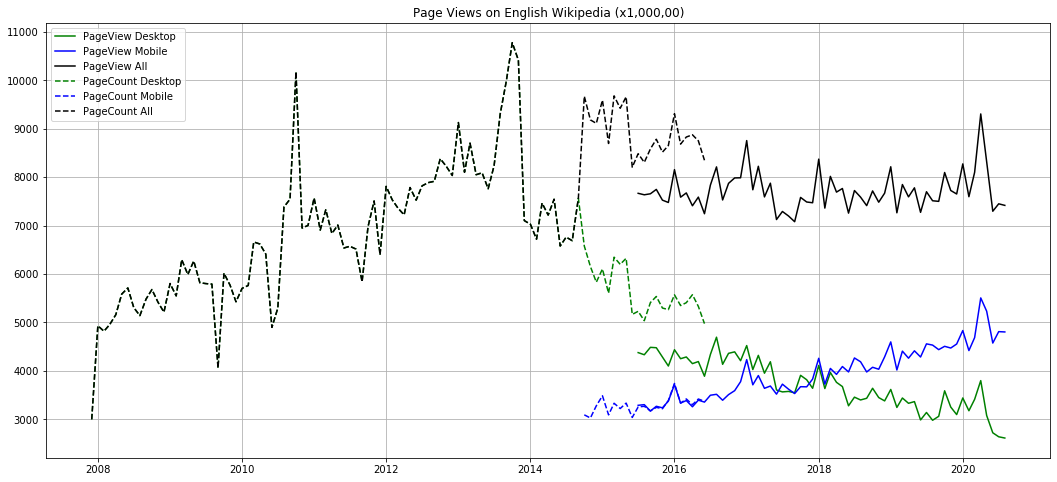

In [49]:
plt.figure(figsize=(18, 8))

plt.plot(merged_df['date'], merged_df['pageview_desktop_views']/1000000,color='g')
plt.plot(merged_df['date'], merged_df['pageview_mobile_views']/1000000,color='b')
plt.plot(merged_df['date'], merged_df['pageview_all_views']/1000000,color='black')

plt.plot(merged_df['date'], merged_df['pagecount_desktop_views']/1000000,color='g',linestyle='--')
plt.plot(merged_df['date'], merged_df['pagecount_mobile_views']/1000000,color='b',linestyle='--')
plt.plot(merged_df['date'], merged_df['pagecount_all_views']/1000000,color='black',linestyle='--')
plt.legend(["PageView Desktop","PageView Mobile", "PageView All", "PageCount Desktop","PageCount Mobile","PageCount All"])
plt.title("Page Views on English Wikipedia (x1,000,00)")
plt.grid()
plt.savefig("final_visualization.png")